In [1]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import ShuffleSplit
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import VotingClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [3]:
df_train = pd.read_csv('train.csv').drop(columns=['Date'])
df_test  = pd.read_csv('test.csv').drop(columns=['Date'])

train_length = len(df_train)
df_test['RainToday'] = np.zeros(len(df_test))

df = pd.concat([df_train, df_test], sort=False)

Proportion: 8.54 : 1
RainToday 0: 31472
RainToday 1: 3684


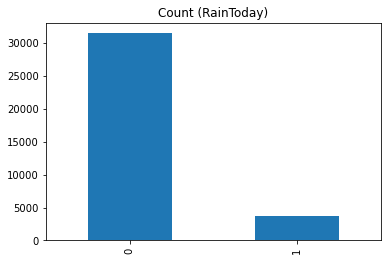

In [4]:
target_count = df_train.RainToday.value_counts()
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
print('RainToday 0:', target_count[0])
print('RainToday 1:', target_count[1])
target_count.plot(kind='bar', title='Count (RainToday)')

In [5]:
df_train.describe()

,MinTemp,MaxTemp,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM
count,28089.000000,28264.000000,28142.000000,28093.000000,28148.000000,28120.000000,28143.000000,28128.000000,28064.000000,28118.000000,28060.000000,28127.000000,28208.000000,28092.000000,28151.000000,35156.000000,28211.000000
mean,12.102032,23.727411,5.704239,7.997373,39.424649,13.799491,18.430319,51.871237,60.238943,1018.033092,1015.465291,4.155401,4.290051,17.188488,22.168286,0.104790,1.794254
std,6.436376,7.090905,3.253679,2.677915,12.900054,8.775068,8.614168,17.788055,10.737416,6.621248,6.594266,2.287310,2.116234,6.523283,6.860412,0.306287,7.185698
min,-8.200000,-3.700000,0.000000,0.000000,7.000000,0.000000,0.000000,0.788279,11.883230,985.000000,977.100000,0.000000,0.000000,-5.600000,-4.200000,0.000000,0.000000
25%,7.500000,18.400000,4.400000,7.993227,31.000000,7.000000,13.000000,40.062533,53.154351,1013.900000,1011.200000,3.000000,3.000000,12.500000,17.100000,0.000000,0.000000
50%,12.000000,23.300000,5.694960,7.993227,39.000000,13.000000,18.435879,52.307109,59.582039,1018.034270,1015.465952,4.167266,4.278120,17.000000,21.800000,0.000000,0.000000
75%,16.800000,28.800000,5.694960,9.200000,46.000000,19.000000,24.000000,63.329570,67.164532,1022.100000,1019.600000,6.000000,6.000000,21.800000,26.850000,0.000000,0.200000
max,31.200000,47.300000,86.200000,14.500000,130.000000,130.000000,78.000000,100.000000,100.000000,1040.600000,1038.900000,9.000000,8.000000,40.200000,44.500000,1.000000,371.000000


In [6]:
non_numerical = [col for col in df.columns if df[col].dtype=='object']

for feacture in df.columns:
    if feacture not in non_numerical:
        df[feacture] = df[feacture].astype(float)

numerical = [col for col in df.columns if col not in non_numerical]

non_numerical

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']

In [7]:
for feacture in non_numerical:
    df[feacture].fillna(df[feacture].mode()[0], inplace=True)
    
for feacture in non_numerical:
    df[feacture] = df[feacture].astype(str)

df = pd.get_dummies(df, columns=non_numerical)
df.shape

(70000, 114)

In [8]:
from sklearn.impute import SimpleImputer

imr = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imr = imr.fit(df.values)

df_imputed_data = imr.transform(df.values)
df_imputed = pd.DataFrame(df_imputed_data)

df_imputed.columns = df.columns

In [9]:
df_imputed.head()

,MinTemp,MaxTemp,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,19.5,21.2,5.69496,0.500000,61.0,31.0,22.0,86.641375,41.810006,1020.40000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.1,15.7,5.69496,5.700000,26.0,9.0,7.0,53.275715,76.598048,1023.70000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20.9,36.1,5.69496,7.993227,39.0,31.0,17.0,15.471574,52.163254,1017.10000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,11.5,23.9,5.69496,7.993227,35.0,7.0,17.0,46.442398,67.664733,1010.20000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.2,20.5,3.20000,7.993227,69.0,9.0,17.0,51.830889,51.770240,1018.03427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [10]:
training_data = df_imputed[:train_length]
X_ans = df_imputed[train_length:].drop(columns = ['RainToday'])
X_ans = X_ans.values

X = training_data.drop(columns=['RainToday'])
y = training_data['RainToday']

In [11]:
# 1. Shuffle

df = shuffle(training_data)

X = df.drop(columns=['RainToday'])
y = df['RainToday']

In [12]:
# 2. Split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [13]:
# 3. RandomOverSample

# smt = SMOTETomek(ratio='auto')
# X_res, y_res = smt.fit_sample(X_train, y_train)

ros = RandomOverSampler(random_state=0)
X_train,  y_train = ros.fit_sample(X_train,  y_train)

In [14]:
# 4. StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_ans_std = sc.transform(X_ans)

In [15]:
X_test_std.shape

(17578, 113)

In [16]:
clf1 = XGBClassifier(max_depth=3, learning_rate=0.05, n_estimators=2000, min_child_weight=1)
clf2 = GradientBoostingClassifier(max_depth=4, learning_rate=0.02, n_estimators=2000)
clf3 = AdaBoostClassifier(learning_rate=0.08, n_estimators=1500)
clf4 = MLPClassifier(alpha=1, max_iter=2000)
clf5 = LinearDiscriminantAnalysis(n_components=1000)
clf6 = RandomForestClassifier(max_depth=5, n_estimators=2000)

In [32]:
classifiers = [
    XGBClassifier(max_depth=3, learning_rate=0.04, n_estimators=4850, min_child_weight=3, subsample=0.8, gamma=0.8, colsample_bytree=1, scale_pos_weight=1),
    # GradientBoostingClassifier(max_depth=4, learning_rate=0.02, n_estimators=2550),
    # AdaBoostClassifier(learning_rate=0.08, n_estimators=1500),
    # MLPClassifier(alpha=1, max_iter=2000), 
    # LinearDiscriminantAnalysis(n_components=1500),
    # RandomForestClassifier(max_depth=5, n_estimators=2000), 
    
    

    # DecisionTreeClassifier(max_depth=5),
    # GaussianNB(),
    # QuadraticDiscriminantAnalysis().
    # KNeighborsClassifier(3),
    # VotingClassifier(estimators=[('XGB', clf1), ('GBC', clf2), ('ABC', clf3), ('MLP', clf4), ('LDA', clf5), ('RFC', clf6)]
    #                         , voting='soft', weights=[10, 10, 9, 9, 8.6, 8.3]) 
    ]
name = [
    # 'RandomForestClassifier()',
    # 'MLPClassifier()',
    'XGBClassifier()',
    'XGBClassifier()',
    'XGBClassifier()',
    # 'AdaBoostClassifier()',
    # 'GradientBoostingClassifier()',
    # 'LinearDiscriminantAnalysis()',

    # 'DecisionTreeClassifier(max_depth=5)',
    # 'GaussianNB()',
    # 'QuadraticDiscriminantAnalysis()',
    # 'KNeighborsClassifier(3)',
    # 'VotingClassifier'
    ]

In [33]:
# model = RandomForestClassifier(criterion='entropy', n_estimators=2000)
# model = SVC(kernel='linear', C=3, random_state=0, probability=True, gamma='auto')
# model = AdaBoostClassifier(n_estimators=2000)

for index, classifier in enumerate(classifiers):
    model = classifier
    model.fit(X_train_std, y_train)

    y_pred_decision = model.predict(X_test_std)
    print(name[index])
    print('Accuracy: %f' % accuracy_score(y_test, y_pred_decision))
    print('f1-score: %f' % f1_score(y_test, y_pred_decision))


XGBClassifier()
Accuracy: 0.855103
f1-score: 0.453316


In [19]:
ans_pred = model.predict(X_ans_std)
df_sap = pd.DataFrame(ans_pred.astype(int), columns = ['RainToday'])
df_sap.to_csv('myAns.csv',  index_label = 'Id')